<a href="https://colab.research.google.com/github/alonsomoros/colab/blob/main/2_4_1_MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install tensorflow==2.13
!pip install keras==2.13.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Reshape, Dropout, UpSampling2D, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

# Dataset Load

We download MNIST dataset, consisting of 60.000 images of 28x28 pixels resolution. Each image defines a handwritten number in greyscale.

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


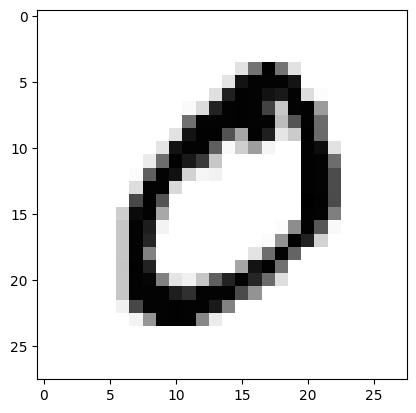

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
plt.imshow(X_train[1], cmap = 'Greys')
print(X_train.shape)

## Preprocessing data

The pixels in the source image are within the range [0, 256] we will normalize this range to [-1, 1] in order to treat this information with neural networks.

In [4]:
X_train = (X_train.astype('float32')/127.5) -1
display(X_train.shape)
X_train = np.expand_dims(X_train, axis=3)
display(X_train.shape) # Add channel dimension

(60000, 28, 28)

(60000, 28, 28, 1)

# Generator definition

In [16]:
def create_generator():
    input = Input(shape=(100,)) # Esto es el ruido, la Z

    # Añade capa al generador...
    x = Dense(128, activation='relu')(input)

    # Activación tanh. Suele dar mejores resultados
    x = Dense(28*28*1, activation='tanh')(x) # La tanh es la más óptima, puedes probar con otras
    # Rango de salida acotado: La función tanh produce valores en el rango [-1, 1]
    # Gradientes más fuertes para actualizar.

    output = Reshape((28, 28, 1))(x)

    generator = Model(input, output)

    return generator

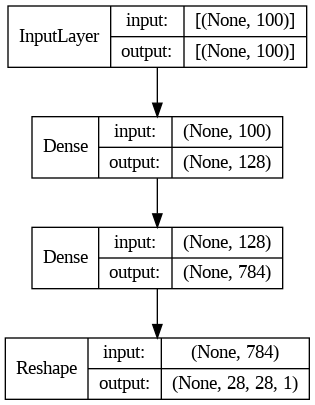

In [17]:
generator = create_generator()
plot_model(generator, show_shapes=True, show_layer_names=False)

# Discriminator definition

In [18]:
def create_discriminator():
    input = Input(shape=(28, 28, 1))

    x = Flatten()(input)

    x = Dense(512, activation='relu')(x)
    # Añadimos las capas que queramos

    output = Dense(1, activation='sigmoid')(x)

    discriminator = Model(input, output)

    return discriminator

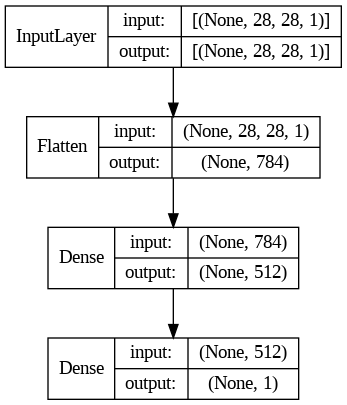

In [19]:
discriminator = create_discriminator()
plot_model(discriminator, show_shapes=True, show_layer_names=False)

# GAN model definition

In [20]:
# Al compilar el modelo se calcula el gráfico computacinal.
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Establecemos que sus parámetros no son entrenables.
# Si quisieramos que este cambio tuviera efecto debríamos recompilar el modelo.
discriminator.trainable = False

# Definimos el modelo combinado.
z = Input(shape=(100,))
validity = discriminator(generator(z))
combined = Model(z, validity)

# OJO!
# Compilamos el modelo.
combined.compile(loss='binary_crossentropy', optimizer=Adam())
# En el combinado no se entrena el discriminador.
# Nos sirve para entrenar el generador.


# Training

In [21]:
# Nuevo: generamos el entrenamiento a mano.
# OJO: No usamos fit
# Usamos train_on_batch para ir lote a lote.

def train(X_train, generator, discriminator, combined, epochs, batch_size=32):
    # La verdad.
    # ground truths (0 fake and 1 real)
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    history = {
        'd_loss' : [],
        'd_acc' : [],
        'g_loss' : []
    }

    for epoch in range(epochs):
        print("----EPOCH " + str(epoch) + '-----')
        for batch in range(int(len(X_train)/batch_size)): # Por cada batch (el conjunto de datos / tamaño del batch)
            # Generamos ruido. 100 valores por cada imagen del batch.
            noise = np.random.normal(0, 1, (batch_size, 100)) # La Z

            # Generamos imágenes con el generador.
            gen_imgs = generator.predict(noise, verbose=0) # Imágenes generadas, al principio todo ruido

            # Recogemos el mimso números de imágenes reales.
            imgs = X_train[batch*batch_size : (batch+1)*batch_size] # Como en SO, se van cogiendo los intervalos correspondientes

            # Con el discriminador (trainable=True) le mostramos
            # imágenes falsas y verdaderas con las etiquetas corresponientes.
            d_loss_real = discriminator.train_on_batch(imgs, valid) # valid es un array de etiquetas de 1 para las imágenes
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # fake es un array de etiquetas de 0 para las imágenes
            # La pérdida es la media de las dos pérdidas
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # Vamos ahora con el generador.
            noise = np.random.normal(0, 1, (batch_size, 100)) # Generamos otro ruido aleatorio
            # En el modelo combinado los pesos del discriminador están congelados
            g_loss = combined.train_on_batch(noise, valid)

            # Para mostrar la evolución:
            history['d_loss'].append(d_loss[0])
            history['d_acc'].append(d_loss[1])
            history['g_loss'].append(g_loss)

            # Plot the progress
            if batch % 50 == 0:
                print ("%d [D loss: %.4f,\t acc.: %.2f%%]\t[G loss: %.4f]" % (batch, d_loss[0], 100*d_loss[1], g_loss))

            if batch % 500 == 0:
                sample_images(epoch, batch, gen_imgs, imgs)

        plot_losses(history)

## Plotting functions

In [22]:
def sample_images(epoch, batch, gen_imgs, imgs):
    plt.rcParams['figure.figsize'] = [15, 5]
    fig, axs = plt.subplots(2, 5)
    fig.suptitle('Epoch: ' + str(epoch) + ', Batch: ' + str(batch), fontsize=16)
    for i in range(5):
        axs[0,i].imshow(gen_imgs[i,:,:,0], cmap='Greys')
        axs[0,i].axis('off')

    for i in range(5):
        axs[1,i].imshow(imgs[i,:,:,0], cmap='Greys')
        axs[1,i].axis('off')
    plt.show()
    plt.close()

In [23]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('batch')
    ax1.legend(loc="upper right")
    ax1.grid()

    ax1.plot(history['d_loss'], label='D loss')
    ax1.plot(history['g_loss'], label='G loss')
    ax1.legend()

    ax2.set_title('D accuracy')
    ax2.set_xlabel('batch')
    ax2.legend(loc="upper right")
    ax2.grid()

    ax2.plot(history['d_acc'], label='Accuracy')
    ax2.legend()

    plt.show()

----EPOCH 0-----
0 [D loss: 0.3868,	 acc.: 79.69%]	[G loss: 2.9774]


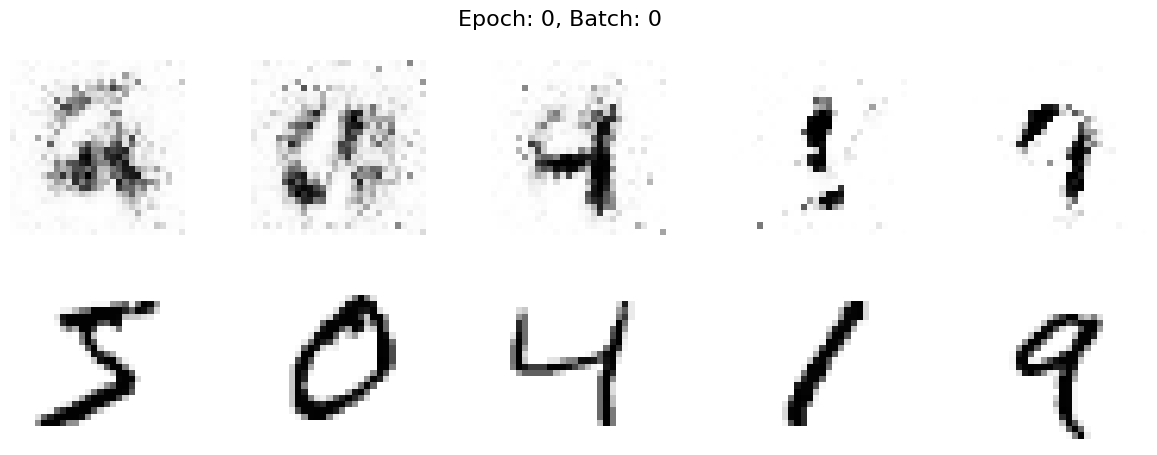

KeyboardInterrupt: 

In [26]:
train(X_train, generator, discriminator, combined, epochs=10, batch_size=32)

---

Creado por **Guillermo Iglesias** (guillermo.iglesias@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">